# LSTM from Scratch for TA

## import packages

In [3]:
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

## Define Function of Activation Function

In [4]:
#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

## Define LSTM Class

In [5]:
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*
                               self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

## Change the Indicators Here!

In [6]:
#hyperparameters
epochs  = 1000
nc      = 10 #units

#datasets
name_dataset = 'PSDN-short'

column_dataset_obs = 'Close'

## Import Dataset

In [7]:
df = pd.read_csv('../Datasets/'+name_dataset+'.csv')
# df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,134.0,134.0,134.0,134.0,134.0,0
1,2017-01-03,135.0,139.0,135.0,139.0,139.0,4500
2,2017-01-04,139.0,139.0,136.0,136.0,136.0,40500
3,2017-01-05,135.0,141.0,135.0,141.0,141.0,6900
4,2017-01-06,136.0,140.0,136.0,140.0,140.0,200
...,...,...,...,...,...,...,...
58,2017-03-23,170.0,170.0,162.0,162.0,162.0,10800
59,2017-03-24,170.0,181.0,144.0,146.0,146.0,13006800
60,2017-03-27,146.0,151.0,146.0,146.0,146.0,190900
61,2017-03-29,140.0,152.0,140.0,146.0,146.0,317600


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,63.000000,63.000000,63.000000,63.000000,63.000000,6.300000e+01
mean,155.253968,158.412698,152.698413,155.365079,155.365079,7.755635e+05
std,12.317007,13.554710,12.055831,11.584614,11.584614,3.308598e+06
min,134.000000,134.000000,120.000000,134.000000,134.000000,0.000000e+00
25%,145.500000,148.000000,144.500000,146.000000,146.000000,1.000000e+03
50%,160.000000,161.000000,153.000000,160.000000,160.000000,1.220000e+04
75%,165.000000,168.000000,163.000000,164.500000,164.500000,9.065000e+04
max,182.000000,204.000000,171.000000,185.000000,185.000000,1.908030e+07


In [21]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0     134.0
1     139.0
2     136.0
3     141.0
4     140.0
      ...  
58    162.0
59    146.0
60    146.0
61    146.0
62    147.0
Name: Close, Length: 63, dtype: float64

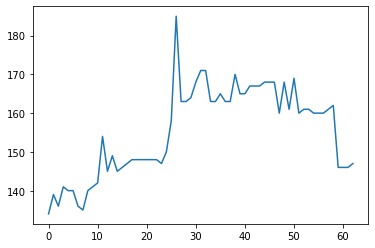

In [22]:
plt.plot(new_df)

## MinMax Scaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
# new_df

In [12]:
xs = new_df

In [14]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 4
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



## Splitting Training and Testing

In [15]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [16]:
training_size, test_size

(50, 13)

In [17]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [18]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.18173345707895763
------------- 2 -------------
0.12145111805067604
------------- 3 -------------
0.10393401464818941
------------- 4 -------------
0.09883408206319179
------------- 5 -------------
0.09733947479945705
------------- 6 -------------
0.09689165651935794
------------- 7 -------------
0.09674775798180502
------------- 8 -------------
0.09669208854013867
------------- 9 -------------
0.09666202281951734
------------- 10 -------------
0.09663937742993077
------------- 11 -------------
0.09661887250067284
------------- 12 -------------
0.09659897461731733
------------- 13 -------------
0.096579238118271
------------- 14 -------------
0.09655953315813974
------------- 15 -------------
0.09653982158209111
------------- 16 -------------
0.09652009185298649
------------- 17 -------------
0.09650034015806418
------------- 18 -------------
0.09648056492337305
------------- 19 -------------
0.096460765220991
------------- 20 -------------
0.09644094030

0.0920523975991722
------------- 183 -------------
0.09200924444508678
------------- 184 -------------
0.09196572386970285
------------- 185 -------------
0.09192183129681124
------------- 186 -------------
0.09187756211016278
------------- 187 -------------
0.09183291165358233
------------- 188 -------------
0.09178787523110343
------------- 189 -------------
0.09174244810712064
------------- 190 -------------
0.0916966255065635
------------- 191 -------------
0.09165040261509068
------------- 192 -------------
0.09160377457930546
------------- 193 -------------
0.09155673650699407
------------- 194 -------------
0.09150928346738589
------------- 195 -------------
0.0914614104914383
------------- 196 -------------
0.09141311257214484
------------- 197 -------------
0.09136438466486924
------------- 198 -------------
0.09131522168770397
------------- 199 -------------
0.09126561852185677
------------- 200 -------------
0.091215570012063
------------- 201 -------------
0.091165070967026

0.08472227328810088
------------- 369 -------------
0.08472275548279434
------------- 370 -------------
0.08472314964002177
------------- 371 -------------
0.084723455277461
------------- 372 -------------
0.08472367195380244
------------- 373 -------------
0.0847237992690652
------------- 374 -------------
0.08472383686485407
------------- 375 -------------
0.08472378442455668
------------- 376 -------------
0.08472364167348227
------------- 377 -------------
0.08472340837894031
------------- 378 -------------
0.08472308435026014
------------- 379 -------------
0.08472266943875228
------------- 380 -------------
0.08472216353761035
------------- 381 -------------
0.08472156658175616
------------- 382 -------------
0.08472087854762726
------------- 383 -------------
0.0847200994529091
------------- 384 -------------
0.08471922935621162
------------- 385 -------------
0.08471826835669276
------------- 386 -------------
0.0847172165936292
------------- 387 -------------
0.084716074245936

0.0859965036912787
------------- 550 -------------
0.08599625419707886
------------- 551 -------------
0.08599591875932373
------------- 552 -------------
0.0859954983552234
------------- 553 -------------
0.08599499395318318
------------- 554 -------------
0.08599440651282225
------------- 555 -------------
0.08599373698499675
------------- 556 -------------
0.08599298631182306
------------- 557 -------------
0.08599215542670409
------------- 558 -------------
0.0859912452543569
------------- 559 -------------
0.08599025671084186
------------- 560 -------------
0.0859891907035935
------------- 561 -------------
0.08598804813145382
------------- 562 -------------
0.08598682988470548
------------- 563 -------------
0.08598553684510857
------------- 564 -------------
0.08598416988593631
------------- 565 -------------
0.08598272987201389
------------- 566 -------------
0.08598121765975836
------------- 567 -------------
0.08597963409721891
------------- 568 -------------
0.08597798002411

0.08516251945843965
------------- 735 -------------
0.08515601511461003
------------- 736 -------------
0.08514950354862827
------------- 737 -------------
0.08514298487530257
------------- 738 -------------
0.0851364592080025
------------- 739 -------------
0.0851299266586773
------------- 740 -------------
0.0851233873378729
------------- 741 -------------
0.0851168413547493
------------- 742 -------------
0.08511028881709763
------------- 743 -------------
0.08510372983135679
------------- 744 -------------
0.0850971645026307
------------- 745 -------------
0.08509059293470393
------------- 746 -------------
0.08508401523005826
------------- 747 -------------
0.08507743148988917
------------- 748 -------------
0.08507084181412113
------------- 749 -------------
0.08506424630142384
------------- 750 -------------
0.08505764504922686
------------- 751 -------------
0.08505103815373598
------------- 752 -------------
0.0850444257099479
------------- 753 -------------
0.0850378078116649

0.08406637502638203
------------- 897 -------------
0.08405954689708912
------------- 898 -------------
0.08405271949630232
------------- 899 -------------
0.0840458928388712
------------- 900 -------------
0.0840390669394625
------------- 901 -------------
0.0840322418125639
------------- 902 -------------
0.08402541747248504
------------- 903 -------------
0.08401859393335968
------------- 904 -------------
0.08401177120914986
------------- 905 -------------
0.08400494931364577
------------- 906 -------------
0.0839981282604695
------------- 907 -------------
0.08399130806307686
------------- 908 -------------
0.08398448873475899
------------- 909 -------------
0.08397767028864578
------------- 910 -------------
0.08397085273770584
------------- 911 -------------
0.08396403609475107
------------- 912 -------------
0.08395722037243691
------------- 913 -------------
0.083950405583265
------------- 914 -------------
0.08394359173958517
------------- 915 -------------
0.0839367788535973

In [23]:
X_train.shape[0]

50

In [24]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Report Performance of LSTM Predictions

In [25]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [26]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
print('epoch: ' + str(epochs))
print('units: ' + str(nc))

rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)))

epoch: 1000
units: 10
RMSE: 5.88
MAE: 4.03
MAPE: 2.66


## Visualize Test Data the Prediction and Real Stock

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

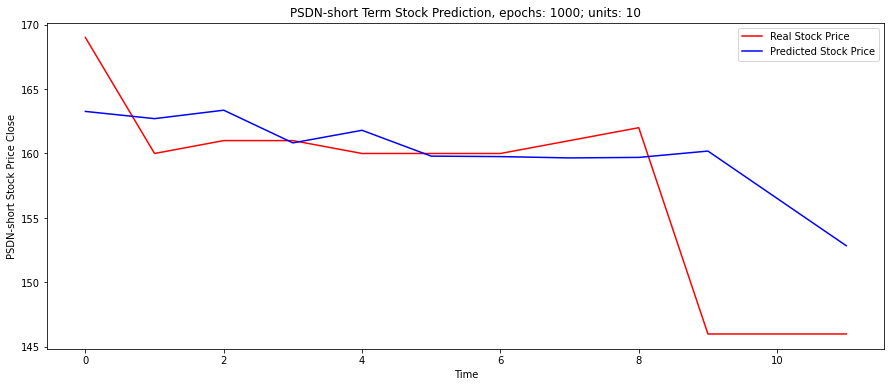

In [28]:
plt.figure()
plt.plot(np.array(out)[:,1], color = 'red', label = 'Real Stock Price')
plt.plot(np.array(out)[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title(name_dataset +' Term Stock Prediction, epochs: '+ str(epochs) +'; units: '+str(nc))
plt.xlabel('Time')
plt.ylabel(name_dataset +' Stock Price '+ column_dataset_obs)
plt.legend()

## Save as a new Dataset

In [17]:
real_price = np.array(out)[:,1]
close_lstm = np.array(out)[:,0]

NameError: name 'out' is not defined

In [18]:
new_data = {'real_price': real_price,
            'Close_LSTM': close_lstm}


NameError: name 'real_price' is not defined

In [19]:
df_new_data = pd.DataFrame(new_data, columns = ['real_price', 'Close_LSTM'])


NameError: name 'new_data' is not defined

In [20]:
df_new_data.to_csv('../Datasets/dataset after prediction/'+name_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(nc) + '.csv', index=False)

NameError: name 'df_new_data' is not defined